## download the data set form this link

https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/code

In [1]:
import pandas as pd
data = pd.read_csv("Data/Training_set.csv")

C:\Users\amrk6\AppData\Local\Temp\ipykernel_11312\4111640712.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [3]:
data['path'] = 'Data/train/' + data['filename']
data.head()

,filename,label,path
0,Image_1.jpg,SOUTHERN DOGFACE,Data/train/Image_1.jpg
1,Image_2.jpg,ADONIS,Data/train/Image_2.jpg
2,Image_3.jpg,BROWN SIPROETA,Data/train/Image_3.jpg
3,Image_4.jpg,MONARCH,Data/train/Image_4.jpg
4,Image_5.jpg,GREEN CELLED CATTLEHEART,Data/train/Image_5.jpg


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
 2   path      6499 non-null   object
dtypes: object(3)
memory usage: 152.4+ KB


In [5]:
class_num = data['label'].nunique()
print("number of unique classes", class_num)

number of unique classes 75


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

##### more info about seaborn.countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html

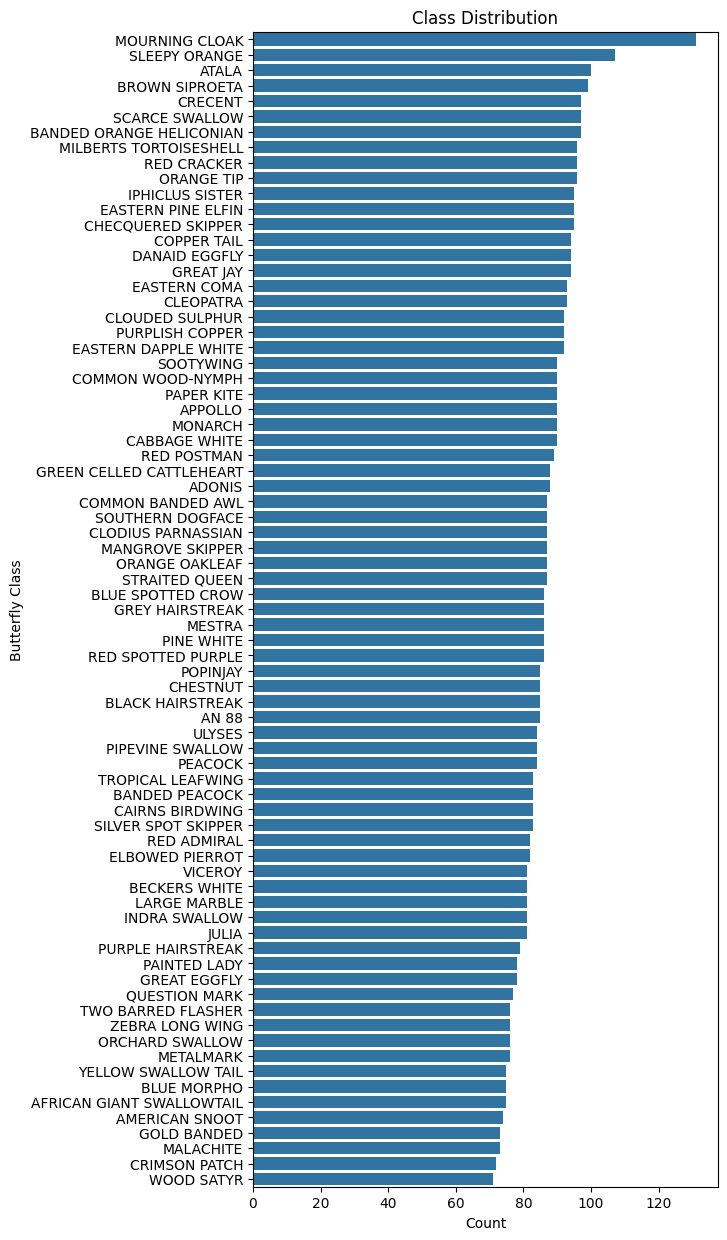

In [7]:
plt.figure(figsize=(6, 15))
sns.countplot(y='label', data=data, order=data['label'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Butterfly Class')
plt.title('Class Distribution')
plt.show()

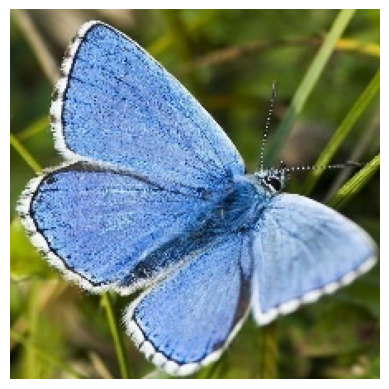

Image shape: (224, 224)
Image mode: RGB


In [8]:
from PIL import Image

def plot_image_from_path(img_path):  #this function plot the image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return img


image_path = data['path'].iloc[1]
image = plot_image_from_path(image_path)

print("Image shape:", image.size)
print("Image mode:", image.mode)

##### split data into training and validation data

In [9]:
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(data, test_size=0.3, random_state=42)

In [10]:
train_data.head()

,filename,label,path
3758,Image_3759.jpg,BLUE MORPHO,Data/train/Image_3759.jpg
5879,Image_5880.jpg,ULYSES,Data/train/Image_5880.jpg
4907,Image_4908.jpg,BLUE MORPHO,Data/train/Image_4908.jpg
5198,Image_5199.jpg,WOOD SATYR,Data/train/Image_5199.jpg
4733,Image_4734.jpg,EASTERN DAPPLE WHITE,Data/train/Image_4734.jpg


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [12]:
def prep_data(train_data, validation_data, batch_size=16):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=40,        # Randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,    # Randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,   # Randomly shift images vertically (fraction of total height)
        shear_range=0.2,          # Randomly apply shear transformations
        zoom_range=0.2,           # Randomly zoom into images
        horizontal_flip=True,     # Randomly flip images horizontally
        fill_mode='nearest'       # Fill in new pixels that may appear after a transformation
    )
    
    train_set = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='path',
        y_col='label',
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='sparse'
    )

    validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    validation_set = validation_datagen.flow_from_dataframe(
        dataframe=validation_data,
        x_col='path',
        y_col='label',
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='sparse'
    )

    return train_set, validation_set

train_set, validation_set = prep_data(train_data, validation_data)

Found 4549 validated image filenames belonging to 75 classes.
Found 1950 validated image filenames belonging to 75 classes.


In [13]:
images, labels = next(train_set)

class_names = train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

In [14]:
train_size = train_set.samples
validation_size = validation_set.samples
print(f"Size of training data: {train_size}")
print(f"Size of validation data: {validation_size}")

Size of training data: 4549
Size of validation data: 1950


# The model

###### Image shape: (180, 180, 3) , classNum -> 75
CONV2d (3, 5) -> 

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(180, 180, 3), num_classes=75):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())


    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


cnn_model = create_cnn_model()

cnn_model.summary()

a:\Pycharm\pycharm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,588,235 (21.32 MB)

 Trainable params: 5,588,235 (21.32 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = cnn_model.fit(
    train_set,
    epochs=25,
    validation_data=validation_set
)

Epoch 1/25


a:\Pycharm\pycharm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 148s 507ms/step - accuracy: 0.0255 - loss: 4.2310 - val_accuracy: 0.0559 - val_loss: 3.8065
Epoch 2/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 112s 391ms/step - accuracy: 0.0685 - loss: 3.8141 - val_accuracy: 0.1338 - val_loss: 3.3537
Epoch 3/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 97s 337ms/step - accuracy: 0.1025 - loss: 3.5227 - val_accuracy: 0.2231 - val_loss: 2.9601
Epoch 4/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 92s 319ms/step - accuracy: 0.1654 - loss: 3.1976 - val_accuracy: 0.3087 - val_loss: 2.5713
Epoch 5/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 93s 323ms/step - accuracy: 0.2234 - loss: 2.9235 - val_accuracy: 0.3626 - val_loss: 2.3910
Epoch 6/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 92s 321ms/step - accuracy: 0.2769 - loss: 2.6520 - val_accuracy: 0.4426 - val_loss: 2.0655
Epoch 7/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 87s 303ms/step - accuracy: 0.3312 - loss: 2.4649 - val_accuracy: 0.4779 - val_loss: 1.9101
Epoch 8/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 85s 297ms/step - accuracy: 0.3815 - loss: 2.2365 - v

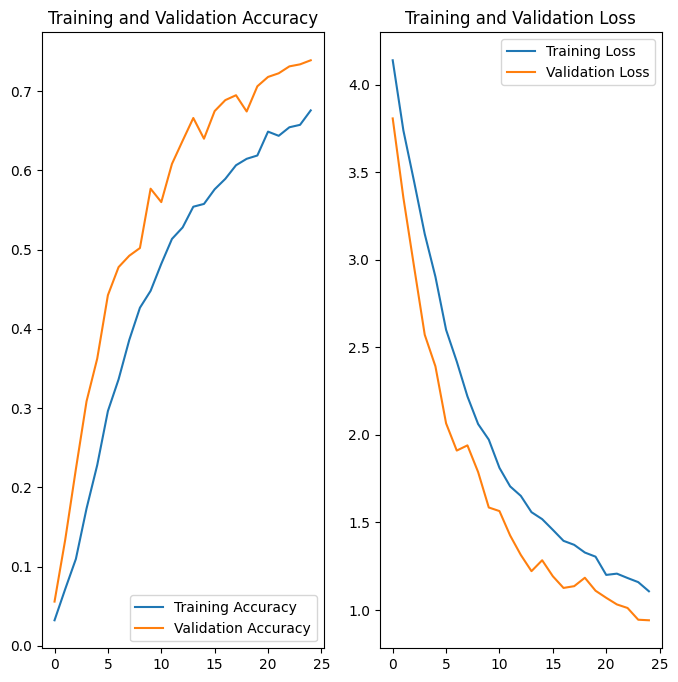

In [18]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)


In [19]:
test_data = pd.read_csv("Data/Testing_set.csv")

In [20]:
test_data.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [21]:
test_data['path'] = 'Data/test/' + test_data['filename']
test_data.head()

,filename,path
0,Image_1.jpg,Data/test/Image_1.jpg
1,Image_2.jpg,Data/test/Image_2.jpg
2,Image_3.jpg,Data/test/Image_3.jpg
3,Image_4.jpg,Data/test/Image_4.jpg
4,Image_5.jpg,Data/test/Image_5.jpg


In [24]:
def prep_test_data_unlabeled(test_data, batch_size=16, img_size=(180, 180)):
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    
    test_set = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='path',
        y_col=None,  # No labels
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None,  # No labels
        shuffle=False  # Ensure data is not shuffled for consistent evaluation
    )

    return test_set

# Assuming test_data is a DataFrame with image paths
test_set_unlabeled = prep_test_data_unlabeled(test_data)

# Number of test samples
test_size = test_set_unlabeled.samples
print(f"Size of testing data: {test_size}")


Found 2786 validated image filenames.
Size of testing data: 2786


In [27]:
class_labels = list(train_set.class_indices.keys())

In [29]:
import numpy as np
# Predict on the test set
predictions = cnn_model.predict(test_set_unlabeled)
predicted_classes = np.argmax(predictions, axis=1)


175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step


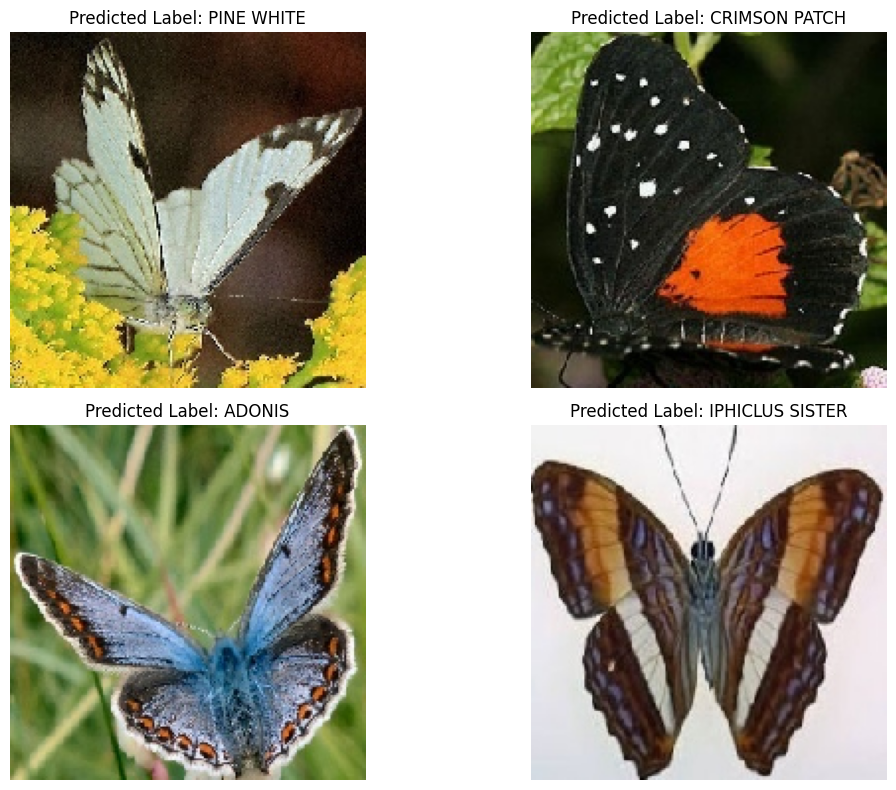

In [34]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    img = load_img(test_set_unlabeled.filepaths[i], target_size=(180, 180))
    plt.imshow(img)
    plt.title(f"Predicted Label: {class_labels[predicted_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()